# Data Ingestion Pipeline

### Loading npy(s)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

In [2]:
processed_dataset  = "processed_data"

In [3]:
from scipy.ndimage import zoom
import os

# numero di sample richiesti
N = len(next(os.walk("%s/voxelizations" % processed_dataset))[2])


# carico il training set
print("Caricamento training set...")

voxelizations      = []
voxelization_specs = []
centers_of_mass    = []
finger_prints      = []
anchors            = []

for i in range(N):
    voxelization       = jnp.array(np.load("%s/voxelizations/voxelization_%d.npy"           % (processed_dataset,i)))
    voxelization_spec  = jnp.array(np.load("%s/voxelization_specs/voxelization_spec_%d.npy" % (processed_dataset,i)))
    center_of_mass     = jnp.array(np.load("%s/centers_of_mass/center_of_mass_%d.npy"       % (processed_dataset,i)))
    finger_print       = jnp.array(np.load("%s/finger_prints/finger_print_%d.npy"           % (processed_dataset,i)))
    anchor             = jnp.array(np.load("%s/anchors/anchor_%d.npy"                       % (processed_dataset,i)))
    
    voxelization_specs.append(voxelization_spec)
    voxelizations.append(zoom(voxelization,(1./2.,1./2.,1./2.)))
    centers_of_mass.append(center_of_mass)
    finger_prints.append(finger_print)
    anchors.append(anchor)
    
    if int( i / (N / 10)) != int( (i + 1)/ (N/10) ):
        print("%d su %d" % (i , N))

Caricamento training set...
30 su 301
60 su 301
90 su 301
120 su 301
150 su 301
180 su 301
210 su 301
240 su 301
270 su 301
300 su 301


# Train Test Split

In [4]:
indici_train = np.arange(len(voxelizations)) < int(len(voxelizations) * .8)
indici_test  = ~indici_train         

# Batch extraction

In [106]:
def extract_dataset(N = 150,window_size = 8):
    X_train,F_train,Y_train = [],[],[]
    X_test ,F_test ,Y_test  = [],[],[]
     
    selezionati_train = np.random.choice(
                            np.arange(                 # isolo gli indici interi riguardandi    
                                len(voxelizations)     # il training set
                            )[indici_train] , size = N
                        )
    selezionati_test = np.random.choice(
                            np.arange(                 # isolo gli indici interi riguardandi
                                len(voxelizations)     # il test set
                            )[indici_test] , size = N  
                        )
    ##### TRAIN
    for sample in selezionati_train:
        curr_vox        = voxelizations[sample]
        x_min,x_max,y_min,y_max,z_min,z_max = curr_vox_specs  = voxelization_specs[sample]
        
        i,j,k    = np.array([
                            np.random.choice(q)
                        for q in curr_vox.shape
                   ])          # centro della subvoxel grid in termini di indici
        
        x,y,z    = (
                        (1. *i)/curr_vox.shape[0] * (x_max - x_min) + x_min,
                        (1. *j)/curr_vox.shape[1] * (y_max - y_min) + y_min,
                        (1. *k)/curr_vox.shape[2] * (z_max - z_min) + z_min
                   ) 
        center   = np.array([x,y,z])
        
        curr_vox = np.pad(curr_vox, 
                          pad_width = ((window_size,window_size),(window_size,window_size),(window_size,window_size))
                         )
        X_train.append( curr_vox[ 
                            (i+window_size) - window_size: (i+window_size) + window_size,
                            (j+window_size) - window_size: (j+window_size) + window_size,
                            (k+window_size) - window_size: (k+window_size) + window_size
                          ] )
        F_train.append(finger_prints[sample])
        Y_train.append( np.sum((center  - centers_of_mass[sample])**2) )
    
    
    #### TEST
    for sample in selezionati_test:
        curr_vox        = voxelizations[sample]
        x_min,x_max,y_min,y_max,z_min,z_max = curr_vox_specs  = voxelization_specs[sample]
        
        i,j,k    = np.array([
                            np.random.choice(q)
                        for q in curr_vox.shape
                   ])          # centro della subvoxel grid in termini di indici
        
        x,y,z    = (
                        (1. *i)/curr_vox.shape[0] * (x_max - x_min) + x_min,
                        (1. *j)/curr_vox.shape[1] * (y_max - y_min) + y_min,
                        (1. *k)/curr_vox.shape[2] * (z_max - z_min) + z_min
                   ) 
        center   = np.array([x,y,z])
        
        curr_vox = np.pad(curr_vox, 
                          pad_width = ((window_size,window_size),(window_size,window_size),(window_size,window_size))
                         )
        X_test.append( curr_vox[ 
                            (i+window_size) - window_size: (i+window_size) + window_size,
                            (j+window_size) - window_size: (j+window_size) + window_size,
                            (k+window_size) - window_size: (k+window_size) + window_size
                          ] )
        F_test.append(finger_prints[sample])
        Y_test.append( np.sum((center  - centers_of_mass[sample])**2) )        
        
    return (jnp.array(X_train),jnp.array(F_train),jnp.array(Y_train)), (jnp.array(X_test),jnp.array(F_test),jnp.array(Y_test))

# Reward

In [141]:
def predict(W,Wf,X,F):
    O     = (
         jnp.linspace(-int(W.shape[0]/2),int(W.shape[0]/2),W.shape[0])[:,None,None]**2 +
         jnp.linspace(-int(W.shape[1]/2),int(W.shape[1]/2),W.shape[1])[None,:,None]**2 +
         jnp.linspace(-int(W.shape[2]/2),int(W.shape[2]/2),W.shape[2])[None,None,:]**2    
    ) < 4.
    Y_hat = jax.vmap(lambda x,f: (x*(W + O*(f @ Wf))).sum())(X,F)
    return Y_hat
def corr(x,y):
    return ((x - x.mean())@(y - y.mean()))/(jnp.linalg.norm(x - x.mean())*jnp.linalg.norm(y - y.mean()))
def reward(W,Wf,X,F,Y):
    Y_hat = predict(W,Wf,X,F)
    return corr(Y_hat,Y)
reward = jax.jit(reward)
grad   = jax.jit(jax.grad(reward, argnums = (0,1)))

# Computational Loop

L'idea é quella di utilizzare una <b> ascesa del gradiente stocastica </b> per massimizzare la correlazione tra l'output del modello e la distanza al quadrato tra il <b> punto che rappresenta il centro della voxelgrid selezionata e il punto effettivo di attachment del ligando </b>.
Il modello prende in ingresso 
1. la subvoxelgrid centrata nel punto di cui si vuole valutare la bontá
2. la finger print del ligando
I parametri $\theta$ sono rappresentati da un tensore ${\bf W}$ che agisce come un funzionale lineare nello spazio delle subvoxelgrid di ordine $n$ e un vettore ${\bf W_f}$ che agisce invece come funzionale nello spazio delle fingerprint

In [142]:
%matplotlib qt5

In [143]:
window = 10               # grandezza della finestra
np.random.seed(123)       # fisso il seed per la riproducibilitá 
W      = np.random.normal(size = (2*window,2*window,2*window))
Wf     = np.random.normal(size = 2048) * 1e-5 # small!
plt.figure()

# dati del grafico

validation_scores = []

# ciclo di calcolo

for i in range(2000):
    (X_train_curr, F_train_curr,Y_train_curr) , (X_test_curr, F_test_curr,Y_test_curr) = extract_dataset(window_size=window)
    g  = grad(W,Wf,X_train_curr,F_train_curr,Y_train_curr)
    W  += 1e-1 * g[0]
    Wf += 1e-1 * g[1]
    print( i, reward(W,Wf,X_train_curr,F_train_curr,Y_train_curr), reward(W,Wf,X_test_curr,F_train_curr,Y_test_curr)  )
   
    validation_score = reward(W,Wf,X_test_curr,F_train_curr,Y_test_curr)
    validation_scores.append(validation_score)
    
    plt.scatter(i, validation_score, s = 50., color = 'black')
    if i % 100 == 0:
        plt.show()
        plt.pause(1e-12)

0 -0.113762364 -0.038129564
1 -0.2619094 -0.18575272
2 -0.09362848 -0.053635508
3 -0.21875773 -0.23583655
4 -0.25569275 -0.09491516
5 -0.1167151 -0.16256006
6 -0.085941054 -0.12958542
7 -0.18007573 0.00701859
8 -0.17736097 -0.14720504
9 -0.12548666 -0.20310779
10 -0.12679635 -0.006765422
11 -0.15963149 -0.19096367
12 -0.21819198 -0.14478797
13 -0.056784812 -0.015661824
14 -0.0014058976 -0.11295688
15 0.026324121 -0.013496721
16 -0.06851149 -0.08267338
17 0.03379672 -0.083817035
18 -0.06372693 -0.078257844
19 0.029982079 0.0065799635
20 -0.09524874 -0.08198768
21 -0.2536872 -0.18338402
22 -0.029955612 -0.06685433
23 -0.040766235 -0.124371156
24 -0.027997132 0.07115716
25 0.16547869 0.02306032
26 -0.04067182 -0.018659426
27 -0.031361397 -0.021856837
28 -0.059452724 -0.05361285
29 -0.03105174 0.04556072
30 -0.0063767917 0.0931982
31 -0.054361526 -0.15490276
32 -0.20210919 -0.123552516
33 -0.04642885 -0.13250902
34 0.05985127 -0.047963586
35 -0.17397542 -0.00735509
36 0.017544106 -0.062696

312 0.174967 0.27218154
313 0.3511337 0.0896918
314 0.1700145 0.15024818
315 0.20690534 0.130357
316 0.1954851 0.11741794
317 0.23178379 0.12606125
318 0.22898275 0.14794682
319 0.10740936 0.20274277
320 0.30235618 0.25751784
321 0.07724669 0.17861405
322 0.061463244 0.2224323
323 0.20739959 0.29818508
324 0.2487605 0.13917974
325 0.2642029 0.09085595
326 0.17580436 0.298002
327 0.21882486 0.18471965
328 0.15784632 0.18421733
329 0.23439318 0.2701
330 0.2703667 0.21114443
331 0.28330487 0.20154868
332 0.1534833 0.23122188
333 0.20072216 0.4162477
334 0.17814526 0.23717447
335 0.24687992 0.19497216
336 0.16093035 0.22136314
337 0.3045639 0.22997929
338 0.11055225 0.13006014
339 0.20098379 0.12770702
340 0.31316712 0.039309237
341 0.1518936 0.29776105
342 0.26277208 0.1042362
343 0.29444376 0.14205395
344 0.24477133 0.3032515
345 0.18321972 0.15896325
346 0.2046857 0.108340934
347 0.1975254 0.09371041
348 0.27998385 0.24045816
349 0.25434133 0.26588765
350 0.13766666 0.14036316
351 0.264

633 0.2585941 0.2573738
634 0.41646796 0.20089576
635 0.37000686 0.23438987
636 0.3716231 0.22133356
637 0.31624904 0.25817367
638 0.36846516 0.21203381
639 0.24366738 0.33967325
640 0.34429455 0.30072787
641 0.22108729 0.29154292
642 0.3548944 0.22092848
643 0.2812625 0.20978758
644 0.29457948 0.13881968
645 0.3400668 0.1558445
646 0.28461805 0.36296794
647 0.40523148 0.21575692
648 0.20704345 0.24791802
649 0.3506982 0.28289914
650 0.4046589 0.3345204
651 0.30381098 0.24649888
652 0.28648117 0.18444888
653 0.2785673 0.09360454
654 0.30957976 0.16639651
655 0.33043557 0.26948494
656 0.43369776 0.35420567
657 0.40258372 0.28349724
658 0.31295088 0.21370332
659 0.20961496 0.29851216
660 0.34159678 0.3246429
661 0.37286222 0.36819282
662 0.16966504 0.23902886
663 0.3498271 0.39001256
664 0.35970098 0.28655693
665 0.35861555 0.18731259
666 0.29471272 0.3249458
667 0.37335524 0.09705726
668 0.19850294 0.38615996
669 0.37174803 0.23911475
670 0.29188356 0.39536744
671 0.44691628 0.2728404
6

956 0.37696868 0.38778597
957 0.30439055 0.29923737
958 0.35562173 0.38958174
959 0.41647583 0.36090234
960 0.28131986 0.36550686
961 0.41372302 0.3098243
962 0.50683075 0.16783407
963 0.35877678 0.43254158
964 0.31928146 0.22402963
965 0.42916924 0.22579354
966 0.4200125 0.3473672
967 0.37761453 0.31399515
968 0.35170385 0.4113248
969 0.40636885 0.26898897
970 0.4048809 0.31221953
971 0.42752394 0.34565517
972 0.419517 0.3035192
973 0.4220595 0.40859577
974 0.4051384 0.28202665
975 0.44980258 0.42493466
976 0.40039748 0.46667263
977 0.3840388 0.33439866
978 0.46807644 0.3508167
979 0.41569638 0.35488853
980 0.45646504 0.4710192
981 0.41357884 0.29345632
982 0.43593648 0.37358403
983 0.45291618 0.31216964
984 0.38068405 0.34063187
985 0.37075102 0.38477108
986 0.4236247 0.2646163
987 0.40350196 0.41706982
988 0.5379743 0.31187567
989 0.42860708 0.37666073
990 0.46341592 0.44416463
991 0.25662726 0.3173023
992 0.3478519 0.2970451
993 0.40327436 0.23108327
994 0.30002034 0.24227673
995 0

1269 0.43238136 0.4584937
1270 0.44785032 0.28474247
1271 0.5290131 0.52077067
1272 0.61028725 0.44764748
1273 0.35766864 0.46160138
1274 0.50392854 0.44095692
1275 0.42429242 0.44784838
1276 0.5086988 0.38291144
1277 0.51397675 0.422944
1278 0.4165444 0.36800808
1279 0.41667706 0.39013368
1280 0.5075713 0.36449444
1281 0.5102305 0.2708641
1282 0.44923824 0.41423777
1283 0.3816572 0.3601949
1284 0.48376232 0.4465842
1285 0.48080748 0.41771632
1286 0.51055086 0.35528046
1287 0.48859856 0.47974572
1288 0.5380224 0.3915059
1289 0.40679222 0.26487058
1290 0.53759205 0.29943746
1291 0.5216383 0.27325904
1292 0.4663054 0.41941312
1293 0.57456595 0.38328654
1294 0.5271211 0.39872545
1295 0.48361936 0.5527943
1296 0.46639892 0.37812588
1297 0.3780825 0.39543617
1298 0.4895021 0.43936437
1299 0.4301508 0.34009597
1300 0.46047026 0.3612933
1301 0.44457605 0.41774508
1302 0.4756477 0.2723347
1303 0.49266714 0.44810104
1304 0.5538852 0.42874515
1305 0.5086513 0.4078353
1306 0.4467925 0.2903623
130

1582 0.59877664 0.44515085
1583 0.48475045 0.42817906
1584 0.5313635 0.3449774
1585 0.38752657 0.39240888
1586 0.5646562 0.34761217
1587 0.54223895 0.3808905
1588 0.49575543 0.38515908
1589 0.54753906 0.34837618
1590 0.49082416 0.442474
1591 0.5372425 0.45017526
1592 0.5112311 0.47240683
1593 0.62273836 0.29926834
1594 0.47731256 0.3163676
1595 0.5270603 0.51392317
1596 0.48738462 0.3569903
1597 0.4061647 0.44104445
1598 0.47672376 0.369004
1599 0.44323185 0.49575356
1600 0.51261675 0.4009894
1601 0.4500184 0.42050156
1602 0.54327786 0.3274518
1603 0.5159344 0.36250654
1604 0.43562856 0.42690647
1605 0.45037904 0.4431036
1606 0.49628597 0.3447444
1607 0.43057638 0.4646101
1608 0.4407091 0.34227312
1609 0.4590766 0.43057594
1610 0.5809407 0.43132228
1611 0.393986 0.40636224
1612 0.56544197 0.4818629
1613 0.47000164 0.45727062
1614 0.44834283 0.44824094
1615 0.42764264 0.43232006
1616 0.43503514 0.37488654
1617 0.48561653 0.44489783
1618 0.46858767 0.4947329
1619 0.52074534 0.47875798
16

1896 0.5097169 0.26281622
1897 0.4871583 0.502857
1898 0.63201416 0.38639513
1899 0.47980618 0.47589055
1900 0.4924087 0.36599702
1901 0.4707267 0.43764433
1902 0.5766482 0.30780998
1903 0.5469346 0.32665637
1904 0.5382909 0.33190995
1905 0.57587224 0.45587426
1906 0.54114175 0.3820045
1907 0.5627628 0.42108938
1908 0.5777958 0.39427018
1909 0.486828 0.37405
1910 0.4846865 0.41952026
1911 0.49482927 0.42782047
1912 0.42121384 0.37326315
1913 0.49009523 0.42366666
1914 0.46425614 0.4421666
1915 0.5616187 0.453807
1916 0.5551628 0.50988036
1917 0.45463982 0.35394523
1918 0.52232206 0.39236388
1919 0.5076825 0.47079268
1920 0.5207754 0.4412015
1921 0.52164096 0.46000773
1922 0.5701817 0.4024977
1923 0.50975066 0.24392039
1924 0.6078968 0.36819062
1925 0.48077267 0.31439164
1926 0.55062735 0.47263974
1927 0.48539504 0.48518753
1928 0.49645427 0.47257894
1929 0.42383415 0.5309716
1930 0.5350743 0.397627
1931 0.5624723 0.54542637
1932 0.48516917 0.38239065
1933 0.48332867 0.5254398
1934 0.51

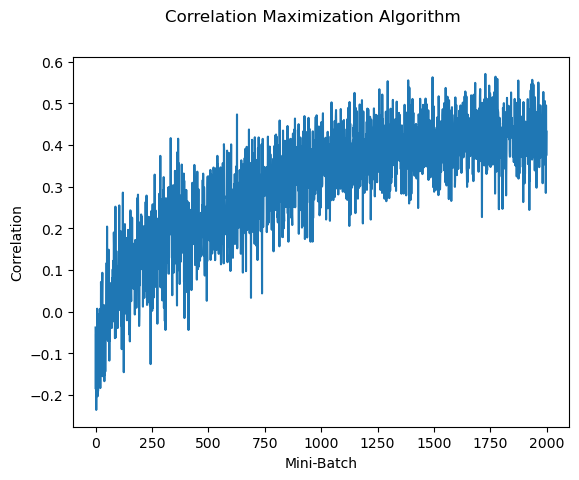

In [144]:
%matplotlib inline
plt.suptitle("Correlation Maximization Algorithm")
plt.ylabel("Correlation")
plt.xlabel("Mini-Batch")
plt.plot(validation_scores)

# Test

Data una voxelizzazione carico gli anchor point e ne calcolo la distanza con il punto di attachment.
Per testare la bontá del classificatore precedente viene analizzata la correlazione tra l'output e la distanza effettiva

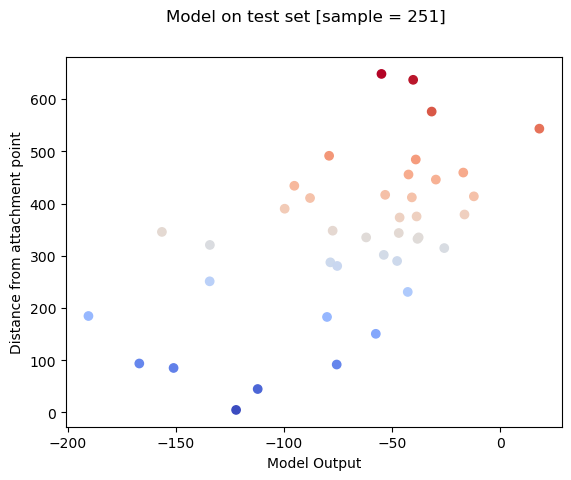

In [155]:
sample = np.arange(len(voxelizations))[indici_test][11]

# costrusico la voxgrid paddata

Nx,Ny,Nz  = voxelizations[sample].shape
curr_vox  = jnp.pad(
                voxelizations[sample],
                pad_width = (
                    (window,window),
                    (window,window),
                    (window,window)
                )
            )

points = []
for a in anchors[sample]:
    correct_distance = jnp.sum( ( a - centers_of_mass[sample] )**2 )
    
    # trovo il voxel associato al punto di ancoraggip
    x_min,x_max,y_min,y_max,z_min,z_max = voxelization_specs[sample]
    x,y,z = a
    i,j,k = (
             int( (x - x_min)/(x_max - x_min) * Nx ),
             int( (y - y_min)/(y_max - y_min) * Ny ),
             int( (z - z_min)/(z_max - z_min) * Nz )
    )

    # estraggo la subvoxelgrid
    subvox = curr_vox[ 
                            (i+window) - window: (i+window) + window,
                            (j+window) - window: (j+window) + window,
                            (k+window) - window: (k+window) + window
                          ]
    # estraggo il farmaco
    f      = finger_prints[sample]
    Y_hat =  predict(W,Wf,subvox[None,:],f[None,:])[0]
    
    points.append([Y_hat,correct_distance])

points = np.array(points)
plt.xlabel("Model Output")
plt.ylabel("Distance from attachment point")
plt.suptitle("Model on test set [sample = %d]" % sample)
plt.scatter(points[:,0],points[:,1],c = points[:,1], cmap = 'coolwarm')

Si osservi come l'output del calssificatore sia effettivamente in grado di "correlare" con la distanza effettiva (punti vicini al punto di ancoraggio producono un output piccolo)